In [2]:
path_main_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"
path_dataset_sizes_table = "../datasets/dataset_sizes_per_model_singlelabel.tsv"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./performance_stability_and_dataset_size/"
export = True

# Forewords

Observation : the poorer performing models seem to perform consistently poorly across methods. One observation from previous work with Pysster is that the dataset size matters => let's plot this.

# Imports

In [3]:
import copy
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [4]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

## Config

In [18]:

with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


## Data

In [9]:
full_summary_table = pd.read_csv(
    path_main_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

In [5]:
table_datasets_sizes = pd.read_csv(path_dataset_sizes_table, sep="\t", header=0, index_col=None) 
table_datasets_sizes['architecture'] = table_datasets_sizes['architecture'].map(lambda v: {'RNAProt':'RNAProt-Extended'}.get(v,v))

# Explore

## Stability

### Table

In [35]:
tmp_stability = []

for DATASET in ['iONMF', 'Mukherjee-PAR-CLIP', 'ENCODE']:
    tmp = full_summary_table.loc[
            lambda df: (df['dataset'] == DATASET) & \
                        (~df['arch'].isin(['GraphProt','BERT-RBP','DeepRiPe','Multi-resBind','MultiRBP','DeepRiPe-1','Multi-resBind-1','MultiRBP-1', 'Pysster-101'])),

            :].copy()

    tmp = pd.merge(
            tmp,
            tmp.groupby('RBP_dataset')['auroc'].median().rename('median_auroc').to_frame(),
            left_on='RBP_dataset',
            right_index=True,
            how='left',
            ).sort_values(by='median_auroc')


    tmp = pd.merge(
            tmp,
            tmp.loc[lambda df: df['model_negativeset']=='negative-1',
                    :].groupby('RBP_dataset')['auroc'].median().rename('median_auroc_neg1').to_frame(),
            left_on='RBP_dataset',
            right_index=True,
            how='left',
            )

    tmp = pd.merge(
            tmp,
            tmp.loc[lambda df: df['model_negativeset']=='negative-2',
                    :].groupby('RBP_dataset')['auroc'].median().rename('median_auroc_neg2').to_frame(),
            left_on='RBP_dataset',
            right_index=True,
            how='left',
            )
    tmp_stability.append(tmp)

tmp_stability = pd.concat(tmp_stability)




### Plots

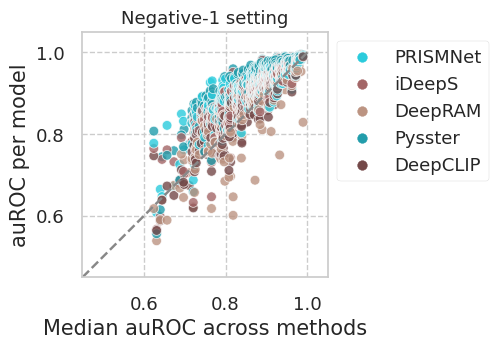

In [40]:
NEGATIVE = 'negative-1'
panel_name = 'b'


figure_name = f"scaterplot_aurocs_vs_median_auroc.{NEGATIVE}"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v*4 for v in FIG3_PANEL_SIZES[panel_name]])

ax1 = fig.add_subplot(1,1,1)

sns.scatterplot(
    data=tmp_stability.loc[
        lambda df: ~df['arch'].isin(['Pysster-101']),
        :].loc[lambda df: df['model_negativeset']==NEGATIVE,:],
    x='median_auroc',
    y='auroc',
    #hue='dataset',
    hue='arch',
    #style='model_negativeset',
    #markers={'negative-1':'^','negative-2':'o'},
    alpha=0.8,
    palette=arch_colors,
    ax=ax1
)
ax1.plot([0,1],[0,1],linestyle='--',color='#888888')

ax1.set_xlim(0.45, 1.05)
ax1.set_ylim(0.45, 1.05)

ax1.set_aspect('equal')


ax1.set_ylabel('auROC per model')
ax1.set_xlabel('Median auROC across methods')
ax1.set_title(f"{NEGATIVE.capitalize()} setting")
ax1.legend(bbox_to_anchor=(1,1))
ax1.legend_.set_title("")


fig.subplots_adjust(left=0.15, right=0.55, bottom=0.15)

if savefig_file:
    my_savefig(savefig_file)


plt.show()

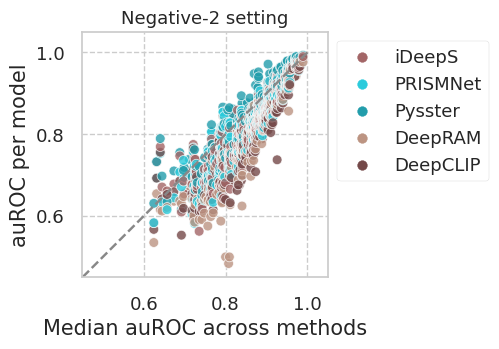

In [39]:

NEGATIVE = 'negative-2'
panel_name = 'b'


figure_name = f"scaterplot_aurocs_vs_median_auroc.{NEGATIVE}"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v*4 for v in FIG3_PANEL_SIZES[panel_name]])

ax1 = fig.add_subplot(1,1,1)

sns.scatterplot(
    data=tmp_stability.loc[
        lambda df: ~df['arch'].isin(['Pysster-101']),
        :].loc[lambda df: df['model_negativeset']==NEGATIVE,:],
    x='median_auroc',
    y='auroc',
    #hue='dataset',
    hue='arch',
    #style='model_negativeset',
    #markers={'negative-1':'^','negative-2':'o'},
    alpha=0.8,
    palette=arch_colors,
    ax=ax1
)
ax1.plot([0,1],[0,1],linestyle='--',color='#888888')

ax1.set_xlim(0.45, 1.05)
ax1.set_ylim(0.45, 1.05)

ax1.set_aspect('equal')


ax1.set_ylabel('auROC per model')
ax1.set_xlabel('Median auROC across methods')
ax1.set_title(f"{NEGATIVE.capitalize()} setting")
ax1.legend(bbox_to_anchor=(1,1))
ax1.legend_.set_title("")


fig.subplots_adjust(left=0.15, right=0.55, bottom=0.15)

if savefig_file:
    my_savefig(savefig_file)


plt.show()

## auROC vs training dataset sizes

### Table

In [6]:
indexing_cols = ['architecture', 'dataset', 'rbp_dataset', 'negative_set', 'fold']

In [10]:
auroc_train_size_df = pd.merge(
    table_datasets_sizes.set_index(indexing_cols)['cts_train'],
    full_summary_table.rename(columns={'arch':'architecture','RBP_dataset':'rbp_dataset','model_negativeset':'negative_set'}
        ).set_index(indexing_cols)['auroc'],
    how='inner',
    left_index=True,
    right_index=True
).reset_index()

In [11]:
auroc_train_size_df.head(5)

,architecture,dataset,rbp_dataset,negative_set,fold,cts_train,auroc
0,DeepCLIP,ENCODE,AGGF1_HepG2,negative-1,0,27154,0.903209
1,DeepCLIP,ENCODE,AGGF1_HepG2,negative-2,0,27154,0.768455
2,DeepCLIP,ENCODE,SF3A3_HepG2,negative-1,0,31854,0.835676
3,DeepCLIP,ENCODE,SF3A3_HepG2,negative-2,0,31854,0.834556
4,DeepCLIP,ENCODE,PABPN1_HepG2,negative-1,0,32288,0.863178


### Correlations

In [12]:
display(
    auroc_train_size_df.groupby(['architecture', 'negative_set']).apply(
        lambda group_df: pd.Series(
            scipy.stats.spearmanr(group_df['auroc'], group_df['cts_train']),
            index=['spearmanr','pval']
        )
    )
)

spearmanr          pval
architecture negative_set                         
DeepCLIP     negative-1     0.320814  1.173774e-08
             negative-2     0.406332  1.958366e-13
DeepRAM      negative-1     0.260223  4.591568e-06
             negative-2     0.410340  1.076175e-13
PRISMNet     negative-1     0.262589  3.731406e-06
             negative-2     0.397345  7.284027e-13
Pysster      negative-1     0.333181  2.911083e-09
             negative-2     0.401298  4.107237e-13
iDeepS       negative-1     0.261992  3.932658e-06
             negative-2     0.373554  1.957035e-11

In [13]:

display(
    auroc_train_size_df.groupby(['architecture',]).apply(
        lambda group_df: pd.Series(
            scipy.stats.spearmanr(group_df['auroc'], group_df['cts_train']),
            index=['spearmanr','pval']
        )
    )
)

,spearmanr,pval
architecture,,
DeepCLIP,0.327105,1.577880e-16
DeepRAM,0.308385,8.971212e-15
PRISMNet,0.266355,2.870771e-11
Pysster,0.310757,5.461331e-15
iDeepS,0.275686,5.371046e-12


### Plot - per dataset sizes

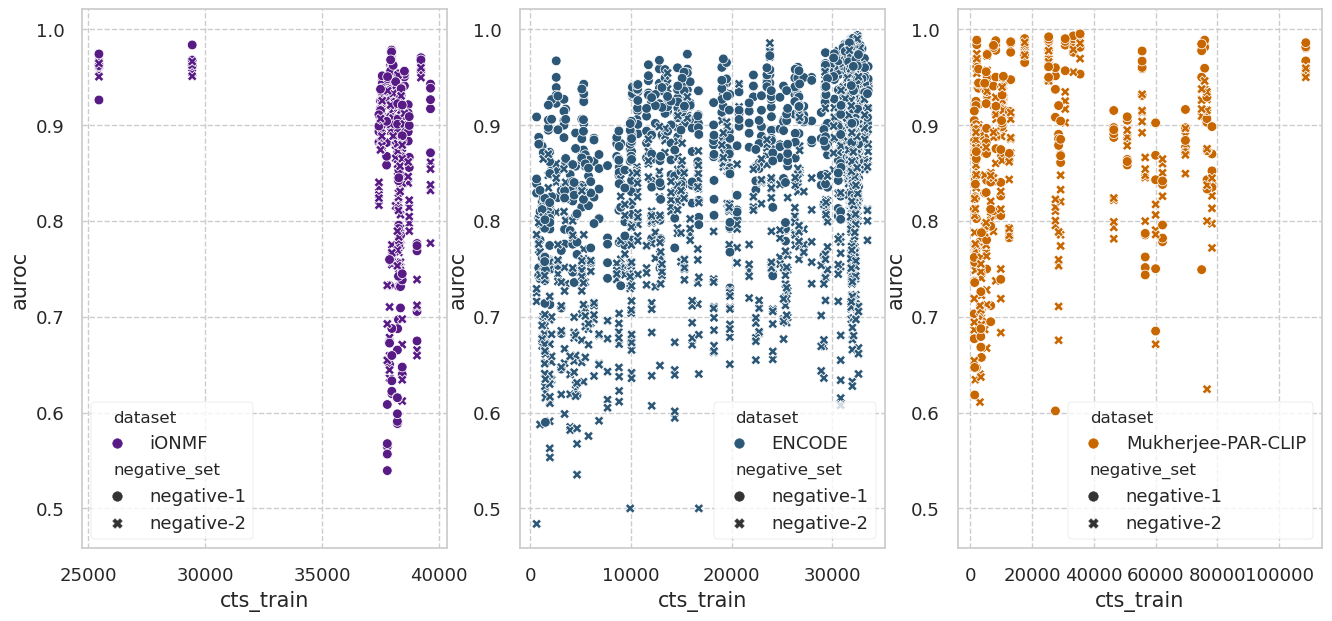

In [19]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2, sharey=ax1)
ax3 = fig.add_subplot(1,3,3, sharey=ax1)


axs = (ax1,ax2,ax3)

for ax, dataset in zip(axs, ['iONMF','ENCODE','Mukherjee-PAR-CLIP']):
    sns.scatterplot(
        data = auroc_train_size_df.loc[
                lambda df: df['dataset']==dataset,:
                ].assign(log_cts_train=lambda df: df['cts_train'].apply(np.log10)),
        x='cts_train',
        y='auroc',
        hue='dataset',
        #style='negative_set',
        style='negative_set',    
        palette=DATASETS_COLORS,
        ax=ax
    )
plt.show()

<AxesSubplot:xlabel='cts_train', ylabel='auroc'>

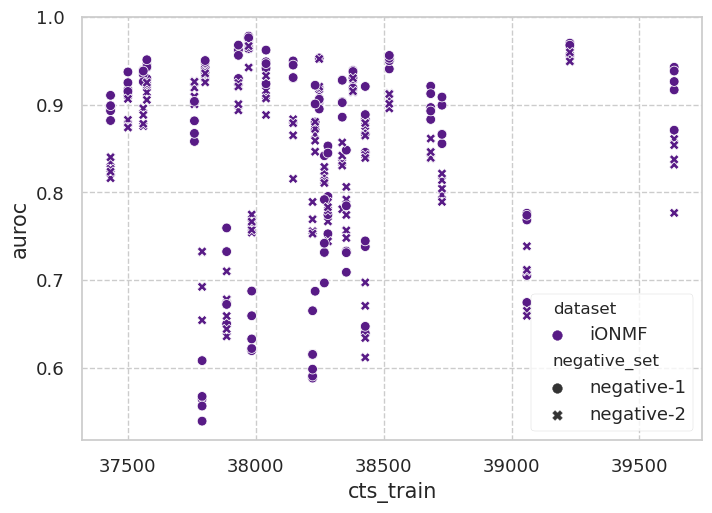

In [20]:
sns.scatterplot(
        data = auroc_train_size_df.loc[
                lambda df: (df['dataset']=='iONMF') & (df['cts_train']>30_000),:
                ].assign(log_cts_train=lambda df: df['cts_train'].apply(np.log10)),
        x='cts_train',
        y='auroc',
        hue='dataset',
        #style='negative_set',
        style='negative_set',    
        palette=DATASETS_COLORS,
)



The correlations show that there's mild positive correlation in ENCODE and PAR-CLIP datasets.

For iONMF, the negative correlation is biased by the datasets for experiments `eIF4AIII_UNKNOWN_CLIPSEQ_7` and `eIF4AIII_UNKNOWN_CLIPSEQ_6`.


### Final plot

In [21]:

tmp_auroc_train_size = auroc_train_size_df.loc[
                            lambda df: (df['dataset'].isin(['ENCODE','Mukherjee-PAR-CLIP'])),
                            :
                            ].copy()

tmp_auroc_train_size['intervalled_cts_train'] = pd.cut(auroc_train_size_df['cts_train'],
                                                        bins=np.arange(-5_000,115_000,3_000),
                                                        include_lowest=True, right=True)
tmp_auroc_train_size['intervalled_cts_train'] = [int(interval.right) for interval in tmp_auroc_train_size['intervalled_cts_train']]





In [14]:
map_order_arch = {
    'Pysster':0,
    'PRISMNet':1,
    'DeepCLIP':2,
    'iDeepS':3,
    'DeepRAM':4,
    'RNAProt-Extended':5,
}

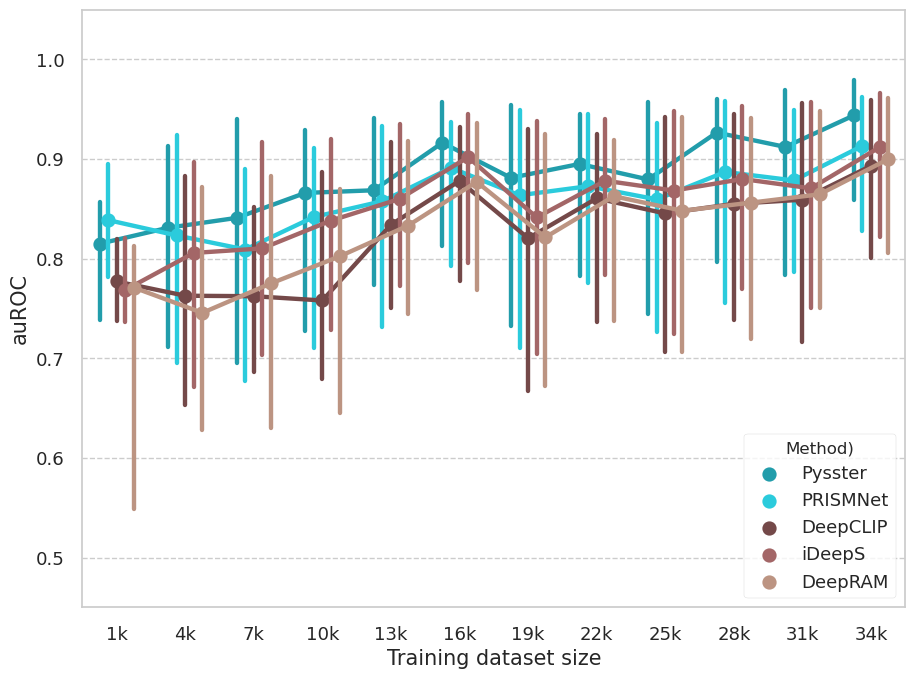

In [25]:
panel_name = 'e'

figure_name = "auroc_vs_train_size"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

# Some models too large number of samples compared to the majority of them.
# Here is a threshold to keep visualization range meaningful.
MAX_CTS_TRAIN = 34_000

plot_scaling_factor = 4.5
fig = plt.figure(figsize=[v*plot_scaling_factor for v in FIG3_PANEL_SIZES[panel_name]])

ax1 = fig.add_subplot(1,1,1,)

sns.pointplot(
    data=tmp_auroc_train_size.assign(
        order_arch=lambda df: df['architecture'].map(map_order_arch),
        ).sort_values(by='order_arch').loc[lambda df: (df['cts_train']<MAX_CTS_TRAIN),:],
    x='intervalled_cts_train',
    y='auroc',
    hue='architecture',
    palette=arch_colors,
    estimator='median',
    errorbar=('pi',75), # percentage interval i.e. 75% of data ~= boxplot box range.
    dodge=0.5,
    ax=ax1,
)

ax1.set_ylim(0.45, 1.05)

ax1.set_ylabel('auROC')
ax1.set_xlabel('Training dataset size')

ax1.set_xticklabels([t.get_text()[:-3]+'k' for t in ax1.get_xticklabels()])

ax1.legend(bbox_to_anchor=(1, 0), loc="lower right")
ax1.legend_.set_title("Method)")

fig.subplots_adjust(right=0.75)
plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file, ext_list=['png', 'svg', 'pdf'])